In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) #set figsize for all

### Read data and concat

Two sources:
* 1969-1988: Center for Disease Control from Jake Vpd
* 1994-2014: Two sets from FiveThirtyEight
  - Center for Disease Control (1994-2003)
  - Social Security (2004-2014)

In [2]:
# First set
vpd = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv').groupby(['year', 'month', 'day'])['births'].sum().reset_index()
vpd['day'] = vpd['day'].astype(int)
# need to remove a few invalid dates with sigma clipping from Jake VPD's code
quartiles = np.percentile(vpd['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.7413 * (quartiles[2] - quartiles[0])
vpd = vpd.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

# Second set
fte_cdc = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/births/US_births_1994-2003_CDC_NCHS.csv')
fte_ss = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/births/US_births_2000-2014_SSA.csv')
fte = pd.concat([fte_cdc, fte_ss[fte_ss['year'] > 2003]], axis=0) #concat two 538 sets
fte = fte.drop(columns=['day_of_week']).rename(columns = {'date_of_month':'day'}) #rename to get same column names

# Concat
birth_df = pd.concat([vpd, fte], axis=0)

In [3]:
birth_df.head()

,year,month,day,births
0,1969,1,1,8486
1,1969,1,2,9002
2,1969,1,3,9542
3,1969,1,4,8960
4,1969,1,5,8390


### Plot birthdays

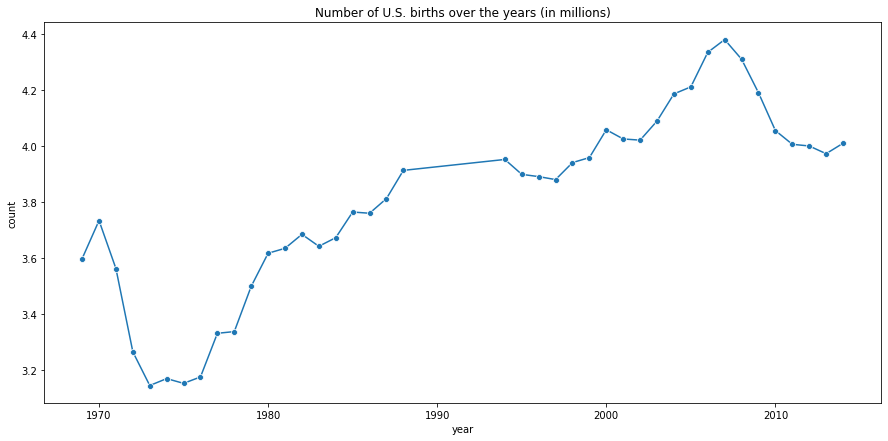

In [4]:
#Plot
data = birth_df.groupby('year')['births'].sum().reset_index(name='count')

ax = sns.lineplot(x=data['year'], y=data['count']/np.power(10, 6), marker='o')
ax.set_title('Number of U.S. births over the years (in millions)')
plt.show()

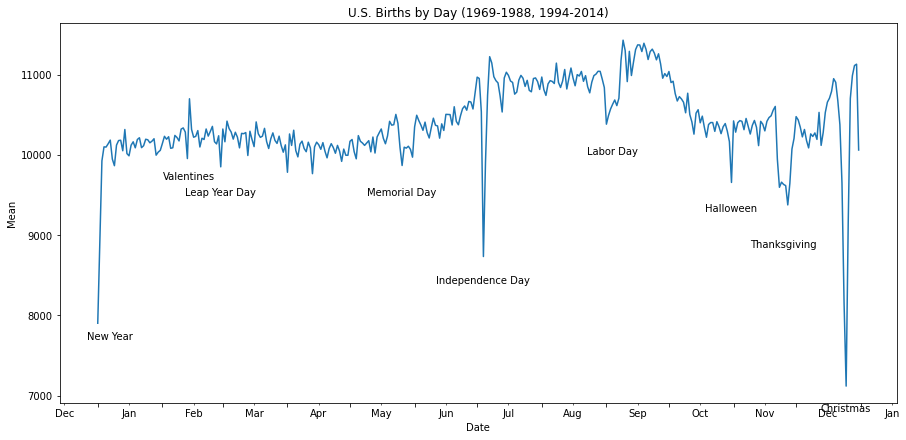

In [23]:
# Get date (pick leap year as placeholder)
birth_df['date'] = pd.to_datetime('2012-'+birth_df['month'].astype(str)+'-'+birth_df['day'].astype(str))
data = birth_df.groupby('date')['births'].mean().reset_index(name='mean').sort_values('date')

# Plot
ax = sns.lineplot(x=data['date'], y=data['mean'])
ax.set(title='U.S. Births by Day (1969-1988, 1994-2014)', ylabel='Mean', xlabel='Date')

# day labels
ax.text(datetime.datetime(2012, 1, 7), 7700, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), 9700, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), 9500, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), 9500, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), 8400, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), 10000, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), 9300, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), 8850, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), 6800, "Christmas", ha='center')

# adjust x-axis
ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

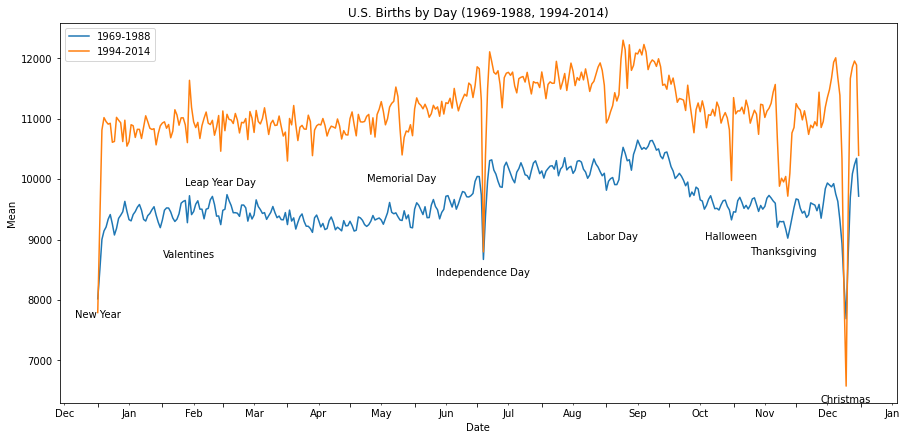

In [25]:
# Has trend changed? Compared the two periods
fig, ax = plt.subplots()

for i, df in enumerate([vpd, fte]):
    df['date'] = pd.to_datetime('2012-'+df['month'].astype(str)+'-'+df['day'].astype(str))
    data = df.groupby('date')['births'].mean().reset_index(name='mean').sort_values('date')
     
    sns.lineplot(x=data['date'], y=data['mean'], ax=ax)    
    
ax.text(datetime.datetime(2012, 1, 1), 7700, "New Year", ha='center')
ax.text(datetime.datetime(2012, 2, 14), 8700, "Valentines", ha='center')
ax.text(datetime.datetime(2012, 2, 29), 9900, "Leap Year Day", ha='center')
ax.text(datetime.datetime(2012, 5, 26), 9950, "Memorial Day", ha='center')
ax.text(datetime.datetime(2012, 7, 4), 8400, "Independence Day", ha='center')
ax.text(datetime.datetime(2012, 9, 4), 9000, "Labor Day", ha='center')
ax.text(datetime.datetime(2012, 10, 31), 9000, "Halloween", ha='center')
ax.text(datetime.datetime(2012, 11, 25), 8750, "Thanksgiving", ha='center')
ax.text(datetime.datetime(2012, 12, 25), 6300, "Christmas", ha='center')

ax.xaxis.set_major_locator(mpl.dates.MonthLocator()) #force major ticks on a monthly time scale
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%b'))

ax.set(title='U.S. Births by Day (1969-1988, 1994-2014)', ylabel='Mean', xlabel='Date')
ax.legend(['1969-1988','1994-2014'])
plt.show()

Some biggest differences in the 21st Century:
- More babies are born
- More births on Valentine's
- BIG drops on major holidays: New Year, Memorial, 4th July, Labor, Halloween, Thanksviging, and Christmas -- Americans take holidays more seriously?

### Understand conception periods

In [98]:
# Get conceived dates
birth_df['date'] = [datetime.datetime(year, month, day) for (year, month, day) in zip(birth_df['year'], birth_df['month'], birth_df['day'])]
birth_df['conceived_date'] = birth_df['date'] - datetime.timedelta(days=280) #40 weeks
birth_df['dayofweek'] = birth_df['conceived_date'].dt.strftime('%A')
birth_df.head()

,year,month,day,births,date,dayofweek,conceived_date,conceived_start
0,1969,1,1,8486,1969-01-01,Wednesday,1968-03-27,1968-04-10
1,1969,1,2,9002,1969-01-02,Thursday,1968-03-28,1968-04-11
2,1969,1,3,9542,1969-01-03,Friday,1968-03-29,1968-04-12
3,1969,1,4,8960,1969-01-04,Saturday,1968-03-30,1968-04-13
4,1969,1,5,8390,1969-01-05,Sunday,1968-03-31,1968-04-14


In [99]:
# Group by
birth_df['conceived_date'] = [datetime.datetime(2012, month, day).strftime('%b %d')
                              for (month, day) in zip(birth_df['month'], birth_df['day'])] #leap year
data = birth_df.groupby(['conceived_date', 'dayofweek'])['births'].mean().reset_index(name='mean')
data.head()

,conceived_date,dayofweek,mean
0,Apr 01,Friday,10488.500000
1,Apr 01,Monday,9817.400000
2,Apr 01,Saturday,8108.600000
3,Apr 01,Sunday,7523.500000
4,Apr 01,Thursday,10609.166667


In [100]:
# Get dummies
for col in ['dayofweek', 'conceived_date']:
    dummy = pd.get_dummies(data[col])
    data = pd.concat([data, dummy], axis=1)

data = data.drop(columns=['conceived_date', 'dayofweek', 'Jan 01', 'Monday']) #drop Jan 01, Monday as they are our base
data.head()

,mean,Friday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr 01,Apr 02,Apr 03,...,Sep 21,Sep 22,Sep 23,Sep 24,Sep 25,Sep 26,Sep 27,Sep 28,Sep 29,Sep 30
0,10488.500000,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9817.400000,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8108.600000,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7523.500000,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10609.166667,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
import statsmodels.api as sm

Y = data['mean']
X = data[data.columns[1:]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     96.58
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        21:45:43   Log-Likelihood:                -18697.
No. Observations:                2561   AIC:                         3.814e+04
Df Residuals:                    2189   BIC:                         4.031e+04
Df Model:                         371                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8249.8520    147.726     55.846      0.000    7960.154    8539.550
Friday       488.9280     28.658     17.061      0.000     432.728     545.128
Saturday   -2115.7264     28.681    -73.767      0.000   -2171.972   -2059.481
Sunday     -2822.7368     28.658    -98.496      0.000   -2878.937   -2766.537
Thursday     519.3080     28.658     18.121      0.000     463.108     575.508
Tuesday      838.5134     28.658     29.259      0.000     782.313     894.714
Wednesday    594.8259     28.658     20.756      0.000     538.626     651.026
Apr 01      1825.7415    207.225      8.810      0.000    1419.364    2232.119
Apr 02      2314.2820    207.225     11.168      0.000    1907.904    2720.659
Apr 03      2237.7522    207.225     10.799      0.000    1831.375    2644.130
Apr 04      2385.3010    207.225     11.511      0.000    1978.924    2791.678
Apr 05      2227.1677    207.225     10.748      0.000    1820.790    2633.545
Apr 06      2193.6403    207.225     10.586      0.000    1787.263    2600.018
Apr 07      2208.7201    207.225     10.659      0.000    1802.343    2615.098
Apr 08      2209.0867    207.225     10.660      0.000    1802.709    2615.464
Apr 09      2139.3844    207.225     10.324      0.000    1733.007    2545.762
Apr 10      2152.5046    207.225     10.387      0.000    1746.127    2558.882
Apr 11      2234.1546    207.225     10.781      0.000    1827.777    2640.532
Apr 12      2262.1879    207.225     10.917      0.000    1855.810    2668.565
Apr 13      1977.8629    207.225      9.545      0.000    1571.485    2384.240
Apr 14      2167.5605    207.225     10.460      0.000    1761.183    2573.938
Apr 15      2195.7558    207.225     10.596      0.000    1789.378    2602.133
Apr 16      2177.2439    207.225     10.507      0.000    1770.866    2583.621
Apr 17      2175.6653    207.225     10.499      0.000    1769.288    2582.043
Apr 18      2233.4951    207.225     10.778      0.000    1827.118    2639.873
Apr 19      2226.4951    207.225     10.744      0.000    1820.118    2632.873
Apr 20      2176.3248    207.225     10.502      0.000    1769.947    2582.702
Apr 21      2148.0498    207.225     10.366      0.000    1741.672    2554.427
Apr 22      2178.4332    207.225     10.512      0.000    1772.056    2584.811
Apr 23      2142.2713    207.225     10.338      0.000    1735.894    2548.649
Apr 24      2133.2665    207.225     10.294      0.000    1726.889    2539.644
Apr 25      2194.1344    207.225     10.588      0.000    1787.757    2600.512
Apr 26      2221.5951    207.225     10.721      0.000    1815.218    2627.973
Apr 27      2137.4677    207.225     10.315      0.000    1731.090    2543.845
Apr 28      2140.9939    207.225     10.332      0.000    1734.616    2547.371
Apr 29      2035.6998    207.225      9.824      0.000    1629.322    2442.077
Ap

In [107]:
# Print top 15 dates
results_df = pd.DataFrame({'date':results.params.index, 'coefficient':results.params.values})
results_df.sort_values(by='coefficient', ascending=False)[:16].reset_index(drop=True)[1:]

,date,coefficient
1,Sep 20,3511.683163
2,Sep 09,3500.279592
3,Sep 19,3473.381973
4,Sep 17,3428.555782
5,Sep 16,3418.895068
6,Sep 21,3418.081973
7,Sep 18,3411.547449
8,Sep 14,3388.940306
9,Sep 15,3387.608163
10,Sep 10,3369.347449


In [113]:
# Plot
results_df =. results_df[7:].sort_values(by='date')

,date,coefficient
7,Apr 01,1825.741497
8,Apr 02,2314.281973
9,Apr 03,2237.752211
10,Apr 04,2385.301020
11,Apr 05,2227.167687
...,...,...
367,Sep 26,3345.174830
368,Sep 27,3325.881973
369,Sep 28,3190.410544
370,Sep 29,3087.290306
